# Proyecto: Forecasting de series temporales con RNN, LSTM y Holt-Winters

En este proyecto analicé una serie univariada con tendencia creciente y estacionalidad anual. Apliqué transformaciones log y diff(log) para estabilizar varianza y centrar la señal; construí un dataset supervisado con ventanas temporales y separé 80/20 en train/test. Entrené y optimicé una RNN simple y una LSTM, y utilicé Holt-Winters como baseline estadístico. Las curvas de aprendizaje mostraron descenso de MSE y buena generalización.

## Hallazgos clave:
- **One-step (sobre LogPassengers)**: ambas redes predijeron con alta precisión — RNN MAPE 4.81% y LSTM MAPE 4.62%. 
- **Multi-step recursivo (escala original)**: se observó acumulación de error con el horizonte; Holt-Winters tuvo el mejor desempeño (MAPE 7.01%), superando a LSTM (9.27%) y RNN (10.73%).
- **Complejidad del modelo:** la RNN alcanzó su óptimo con ~15–30 unidades, mientras que la LSTM requirió ~100 unidades. 
- **Interpretación:** en series univariadas con patrones lineales y estacionales marcados, Holt-Winters puede superar a las redes en multi-step; las RNN/LSTM son competitivas a corto plazo y ganarían ventaja en problemas multivariados con relaciones no lineales y factores exógenos. 


In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import os
import random
import tensorflow as tf


from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Input, Dropout

from sklearn.metrics import  mean_absolute_percentage_error

In [115]:
SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [116]:
# Settings for plots:

plt.rcParams['figure.figsize'] = (10, 6)


plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 2.5

In [117]:
df = pd.read_excel("/Users/ramon/Library/Mobile Documents/com~apple~CloudDocs/Cursos Data Science/Sistemas Dinamicos/passengers.xlsx", index_col = 'Month', parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [118]:
df.shape

(144, 1)

In [119]:
df.isnull().sum()

Passengers    0
dtype: int64

Text(0, 0.5, 'Passengers')

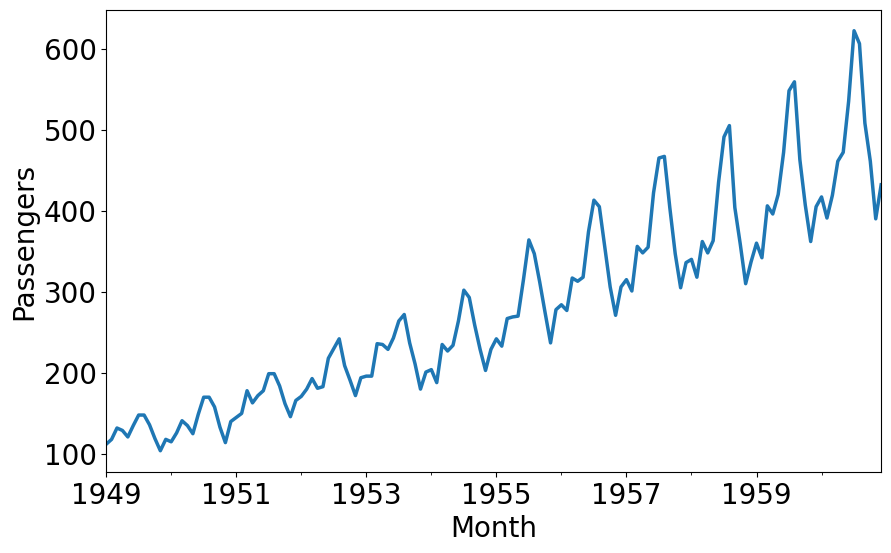

In [120]:
df['Passengers'].plot()
plt.ylabel('Passengers')

In [121]:
df['LogPassengers'] = np.log(df['Passengers'])

Text(0, 0.5, 'LogPassengers')

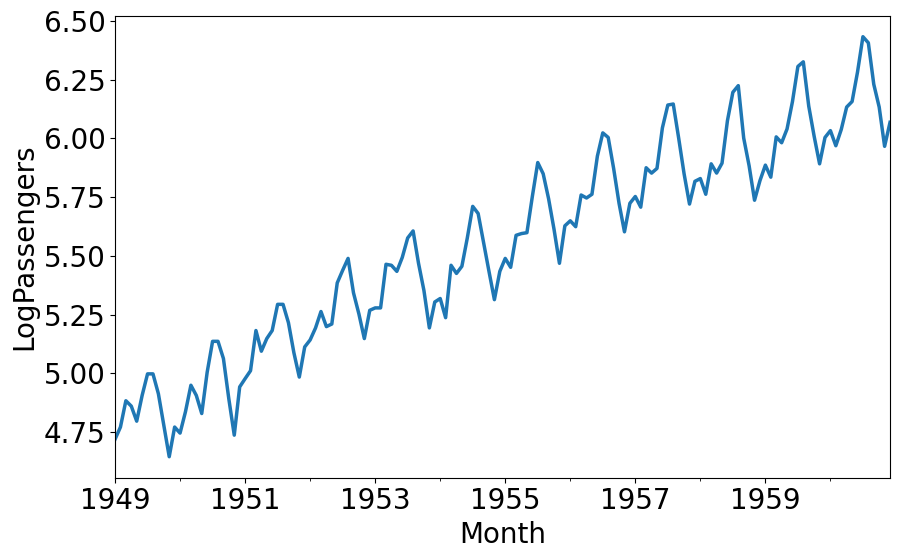

In [122]:
df['LogPassengers'].plot()

plt.ylabel('LogPassengers')

In [123]:
# Voy a usar el 80% de los datos para entrenar.
n_train = int(0.8*len(df['LogPassengers']))
n_test = len(df['LogPassengers']) - n_train
n_test

29

In [124]:
train = df.iloc[:-n_test]
test = df.iloc[-n_test:]

print(f"train.shape = {train.shape}")
print(f"test.shape = {test.shape}")

train.shape = (115, 2)
test.shape = (29, 2)


In [125]:
# Crear la máscara booleana
train_index = df.index <= train.index[-1] # o sea menor o igual al ultimo indice del conjunto de entrenamiento.
test_index = df.index > train.index[-1]


In [126]:
train_index.shape

(144,)

In [127]:
df[train_index]

,Passengers,LogPassengers
Month,,
1949-01-01,112,4.718499
1949-02-01,118,4.770685
1949-03-01,132,4.882802
1949-04-01,129,4.859812
1949-05-01,121,4.795791
...,...,...
1958-03-01,362,5.891644
1958-04-01,348,5.852202
1958-05-01,363,5.894403


Text(0, 0.5, '(LogPassengers).diff()')

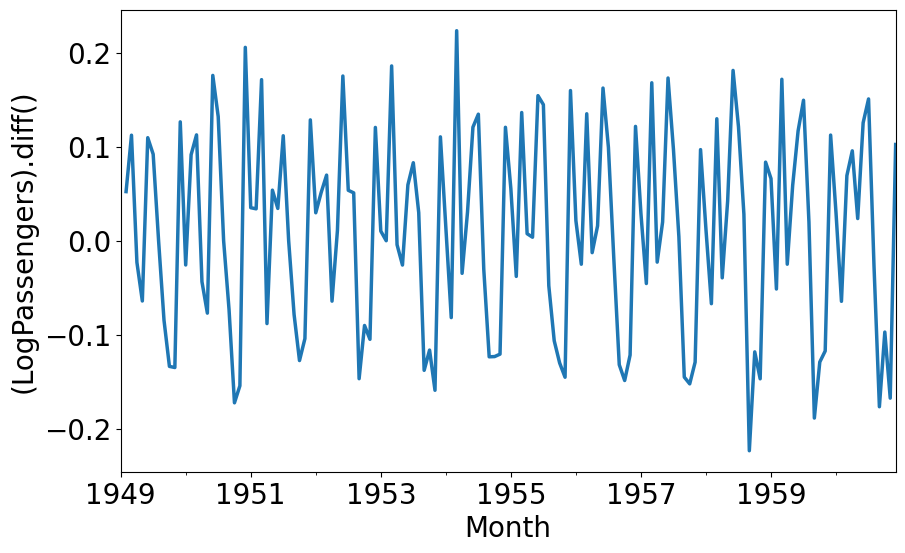

In [128]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()
df['DiffLogPassengers'].plot()

plt.ylabel('(LogPassengers).diff()')

In [129]:
raw_seq = df['DiffLogPassengers'].dropna().to_numpy()
len(raw_seq)

143

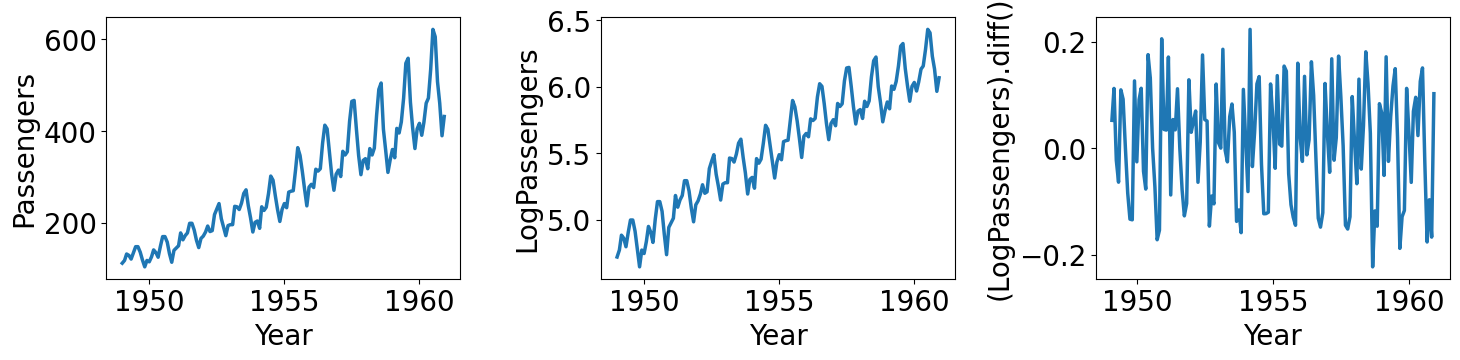

In [130]:
import matplotlib.dates as mdates 

# Crear figura con 1 fila y 3 columnas
fig, axs = plt.subplots(1, 3, figsize=(15, 4))  


# Gráfico 1
axs[0].plot(df['Passengers'])
axs[0].set_ylabel('Passengers')
axs[0].xaxis.set_major_locator(mdates.YearLocator(5))
axs[0].set_xlabel('Year')


# Gráfico 2
axs[1].plot(df['LogPassengers'])
axs[1].set_ylabel('LogPassengers')
axs[1].xaxis.set_major_locator(mdates.YearLocator(5))
axs[1].set_xlabel('Year')

# Gráfico 3
axs[2].plot(df['DiffLogPassengers'])
axs[2].set_ylabel('(LogPassengers).diff()')
axs[2].xaxis.set_major_locator(mdates.YearLocator(5))
axs[2].set_xlabel('Year')


# Ajustar layout para evitar superposición
plt.tight_layout()
plt.show()

## 1) Modelado con Redes Neuronales Recurrentes (RNN):

### 1.1) Separo la serie temporal original en train y test:

Este paso es necesario ya que tengo que hacer una normalizacion de los datos.

### 1.3) Crear dataset - Aplicar `split_sequence`:

Nuestra señal es univariada. Para poder entrenar una RNN hay que convertir (mediante la funcion `split_sequence`) nuestra serie temporal univariada en un conjunto de datos supervisados usando una ventana deslizante.
Entonces lo que queremos es partir nuestra señal en ventanas de `look_back` puntos que tengan asociados el punto que le sigue en la serie temporal al respectivo array.

**Ej:**
Si nuestra señal es `sequene = [1, 2, 3, 4, 5, 6, 7]`
y `look_back = 2`; entonces 

`X = [[1,2],[3,4],[5,6]]`

`y = [3, 5, 7]`

Por lo tanto:
- `sequence`: Es un array 1D que corresponde a nuestra serie temporal.
- `look_back`: Es el tamaño de la ventana que usamos para predecir el y.

In [131]:
def split_sequence(sequence, look_back):
    X, y = list(), list()

    for i in range(look_back, len(sequence)): # Entonces arma sequence.shape[0] - look_back intervalos.
        X.append(sequence[i-look_back:i])
        y.append(sequence[i]) # notar que es [i] porque toma indices, Y sequence[0:i] ecluye la posición i siempre.

    X, y = np.array(X), np.array(y)
    return X, y

Notar que:

`X.shape = (number_samples, look_back)` -> Matriz 2D

`y.shape = (number_samples,)` -> Vector

Y vos sabes que RNN necesita que X tenga la pinta de:
`X.shape = (number_samples, time_step, n_features)`-> Matriz 3D

In [132]:
# Elijo un largo de la ventana:
look_back = 10

# Aplico split_sequence:
X, y = split_sequence(raw_seq.flatten(), look_back) # Importante, fijate que split_sequence espera un 1D array en sequence, por eso pones .flatten() que lo vuelve a su estado inicial de 1D Array.


# Separo en Train y Test:
X_train, y_train = X[:-n_test], y[:-n_test]
X_test, y_test = X[-n_test:], y[-n_test:]


# Cantidad de valores por cada paso temporal. 
n_features = 1 # si tuviese por ejemplo Passengers, Temepratura, esto seria 2 features.

# reshape para RNN:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)

print(f"X shape is: {X.shape}")

print(f"X_train shape is: {X_train.shape}")
print(f"y_train shape is: {y_train.shape}")

print(f"X_test shape is: {X_test.shape}")
print(f"y_test shape is: {y_test.shape}")

X shape is: (133, 10)
X_train shape is: (104, 10, 1)
y_train shape is: (104,)
X_test shape is: (29, 10, 1)
y_test shape is: (29,)


In [133]:
X_train.shape[0] + X_test.shape[0]

133

Fijate que la dimension de X_train + X_test se reduce en look_back, porque estas tomando ventanas de valores.

La cantidad de valores que deberias predecir a opartir de `X_test` es `115`!

### 1.4) RNN - Numero de neuronas:

Para definir una red recurrente vamos a construir un modelo secuencial al que se le agregará a nuestro una capa SimpleRNN.

Luego de la capa recurrente, debemos agregar una capa densa, la cual leerá el último estado del hidden space. En este caso, al tener un problema de regresión en el cual la salida del modelo debe ser un único valor numérico, vamos a utilizar como capa de salida una única unidad con activación lineal.

**Defino el modelo RNN:**

In [34]:
units = [5,10,15,20,25,30,50,100]
mapes = []

for numer_units in units:
    
    model_opt_rnn = Sequential()
    model_opt_rnn.add(Input(shape=(look_back, n_features))) 
    model_opt_rnn.add(SimpleRNN(numer_units, activation='tanh'))
    model_opt_rnn.add(Dense(1, activation='linear'))
    

    model_opt_rnn.compile(optimizer='adam', loss='mse')

    history_opt_rnn = model_opt_rnn.fit(X_train, y_train, epochs=100, verbose=0,validation_data=(X_test, y_test))

    y_pred_train = model_opt_rnn.predict(X_train)
    y_pred_train_inv = np.exp(y_pred_train.reshape(-1,1)).flatten()
    y_train_inv = np.exp(y_train.reshape(-1,1)).flatten()
    mape_train = mean_absolute_percentage_error(y_train_inv, y_pred_train_inv) * 100

    
    y_pred_test = model_opt_rnn.predict(X_test)
    y_pred_test_inv = np.exp(y_pred_test.reshape(-1,1)).flatten()
    y_test_inv = np.exp(y_test.reshape(-1,1)).flatten()    
    mape_test = mean_absolute_percentage_error(y_test_inv, y_pred_test_inv) * 100 

    mapes.append({'model_units':numer_units, 'MAPE Train': mape_train, 'MAPE Test': mape_test})

df_mapes = pd.DataFrame(mapes)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


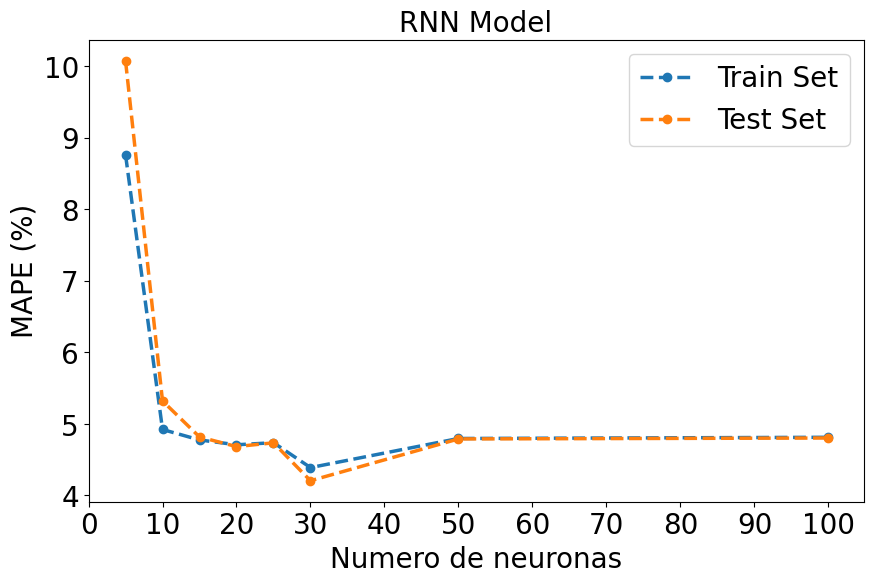

In [37]:
plt.plot(df_mapes['model_units'],
         df_mapes['MAPE Train'], 
         marker='o', 
         linestyle='dashed',
        label='Train Set')
plt.plot(df_mapes['model_units'],
         df_mapes['MAPE Test'], 
         marker='o', 
         linestyle='dashed',
        label='Test Set')
plt.title('RNN Model')
plt.legend()
plt.xlabel('Numero de neuronas')
plt.ylabel('MAPE (%)')
plt.xticks(np.arange(0,110,10))
plt.show()

In [91]:
df_mapes

,model_units,MAPE Train,MAPE Test
0,5,8.765092,10.316652
1,10,4.922502,4.769013
2,15,4.776537,4.540734
3,20,4.708829,4.395062
4,25,4.738057,4.465166
5,30,4.389931,4.002094
6,50,4.796743,4.528874
7,100,4.813580,4.540656


**Defino el modelo LSTM:**

In [43]:
units = [5,20,40,80,100,150,200]
mapes = []

for numer_units in units:
    
    model_opt_lstm = Sequential()
    model_opt_lstm.add(Input(shape=(look_back, n_features))) 
    model_opt_lstm.add(LSTM(numer_units, activation='tanh'))
    model_opt_lstm.add(Dense(1, activation='linear'))
    

    model_opt_lstm.compile(optimizer='adam', loss='mse')

    history_opt_lstm = model_opt_lstm.fit(X_train, y_train, epochs=100, verbose=0,validation_data=(X_test, y_test))

    y_pred_train = model_opt_lstm.predict(X_train)
    y_pred_train_inv = np.exp(y_pred_train.reshape(-1,1)).flatten()
    y_train_inv = np.exp(y_train.reshape(-1,1)).flatten()
    mape_train = mean_absolute_percentage_error(y_train_inv, y_pred_train_inv) * 100

    
    y_pred_test = model_opt_lstm.predict(X_test)
    y_pred_test_inv = np.exp(y_pred_test.reshape(-1,1)).flatten()
    y_test_inv = np.exp(y_test.reshape(-1,1)).flatten()    
    mape_test = mean_absolute_percentage_error(y_test_inv, y_pred_test_inv) * 100 

    mapes.append({'model_units':numer_units, 'MAPE Train': mape_train, 'MAPE Test': mape_test})

df_mapes_lstm = pd.DataFrame(mapes)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


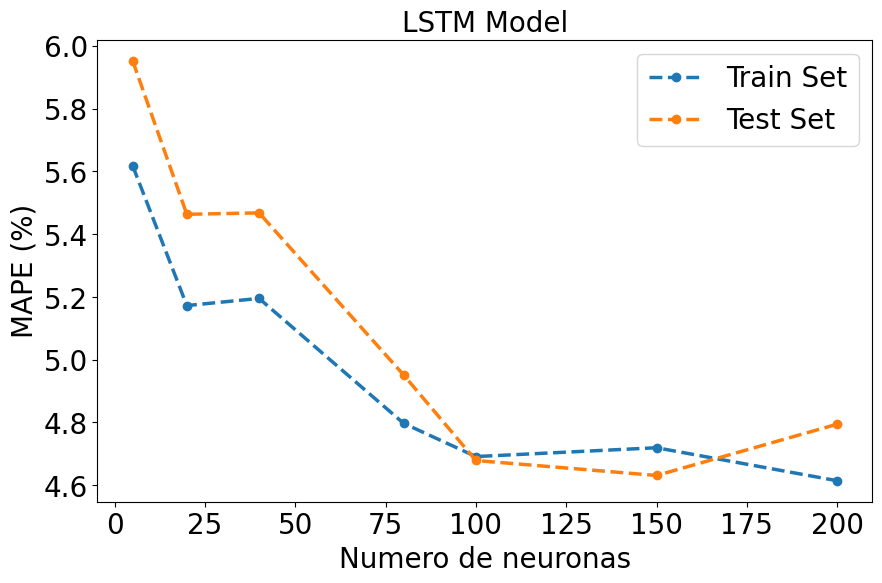

In [51]:
plt.plot(df_mapes_lstm['model_units'],
         df_mapes_lstm['MAPE Train'], 
         marker='o', 
         linestyle='dashed',
        label='Train Set')
plt.plot(df_mapes_lstm['model_units'],
         df_mapes_lstm['MAPE Test'], 
         marker='o', 
         linestyle='dashed',
        label='Test Set')
plt.title('LSTM Model')
plt.legend()
plt.xlabel('Numero de neuronas')
plt.ylabel('MAPE (%)')
plt.xticks(np.arange(0,210,25))
plt.show()

In [91]:
df_mapes_lstm

,model_units,MAPE Train,MAPE Test
0,5,8.765092,10.316652
1,10,4.922502,4.769013
2,15,4.776537,4.540734
3,20,4.708829,4.395062
4,25,4.738057,4.465166
5,30,4.389931,4.002094
6,50,4.796743,4.528874
7,100,4.813580,4.540656


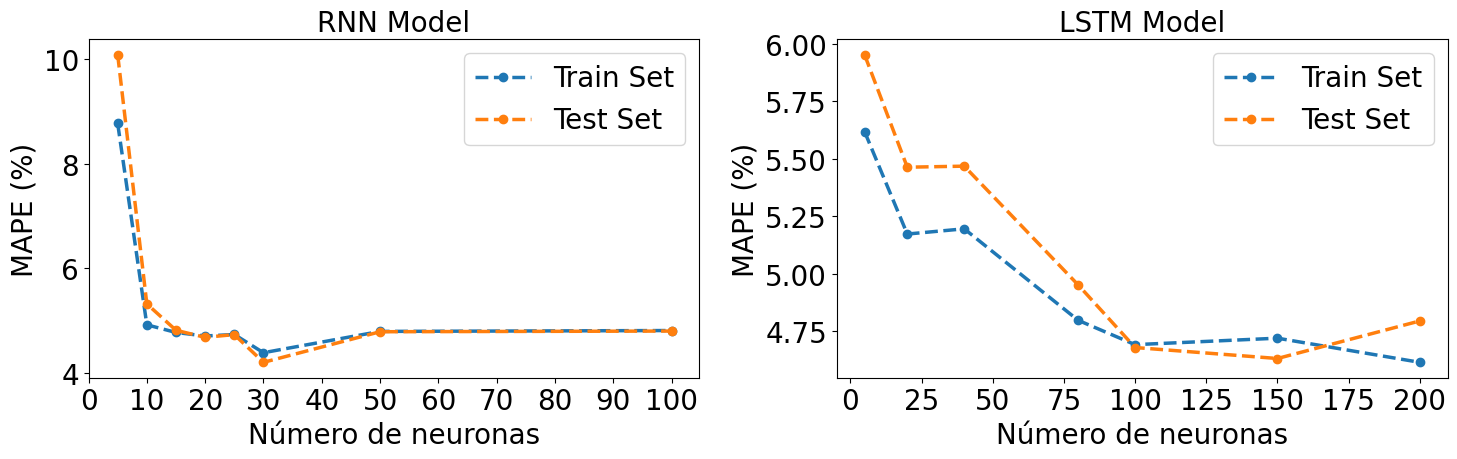

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# --- Gráfico RNN ---
axs[0].plot(df_mapes['model_units'],
            df_mapes['MAPE Train'],
            marker='o',
            linestyle='dashed',
            label='Train Set')

axs[0].plot(df_mapes['model_units'],
            df_mapes['MAPE Test'],
            marker='o',
            linestyle='dashed',
            label='Test Set')

axs[0].set_title('RNN Model')
axs[0].set_xlabel('Número de neuronas')
axs[0].set_ylabel('MAPE (%)')
axs[0].set_xticks(np.arange(0, 110, 10))
axs[0].legend()

# --- Gráfico LSTM ---
axs[1].plot(df_mapes_lstm['model_units'],
            df_mapes_lstm['MAPE Train'],
            marker='o',
            linestyle='dashed',
            label='Train Set')

axs[1].plot(df_mapes_lstm['model_units'],
            df_mapes_lstm['MAPE Test'],
            marker='o',
            linestyle='dashed',
            label='Test Set')

axs[1].set_title('LSTM Model')
axs[1].set_xlabel('Número de neuronas')
axs[1].set_ylabel('MAPE (%)')
axs[1].set_xticks(np.arange(0, 210, 25))
axs[1].legend()

plt.tight_layout()
plt.show()


### 1.3) Entrenar el modelo RNN:

Para definir una red recurrente vamos a construir un modelo secuencial al que se le agregará a nuestro una capa SimpleRNN.

Luego de la capa recurrente, debemos agregar una capa densa, la cual leerá el último estado del hidden space. En este caso, al tener un problema de regresión en el cual la salida del modelo debe ser un único valor numérico, vamos a utilizar como capa de salida una única unidad con activación lineal.

**Defino el modelo RNN:**

In [134]:
# Defino el modelo_rnn:
model_rnn = Sequential()

# Defino el input
model_rnn.add(Input(shape=(look_back, n_features))) 

# Agrego una capa SimpleRNN:
model_rnn.add(SimpleRNN(30, activation='tanh'))

# Agrego una capa de salida lineal:
model_rnn.add(Dense(1, activation='linear'))

# Compilamos el modelo:
model_rnn.compile(optimizer='adam', loss='mse')

**Entrenamos el modelo RNN:**

In [135]:
history = model_rnn.fit(X_train, y_train, epochs=100, verbose=0,validation_data=(X_test, y_test))

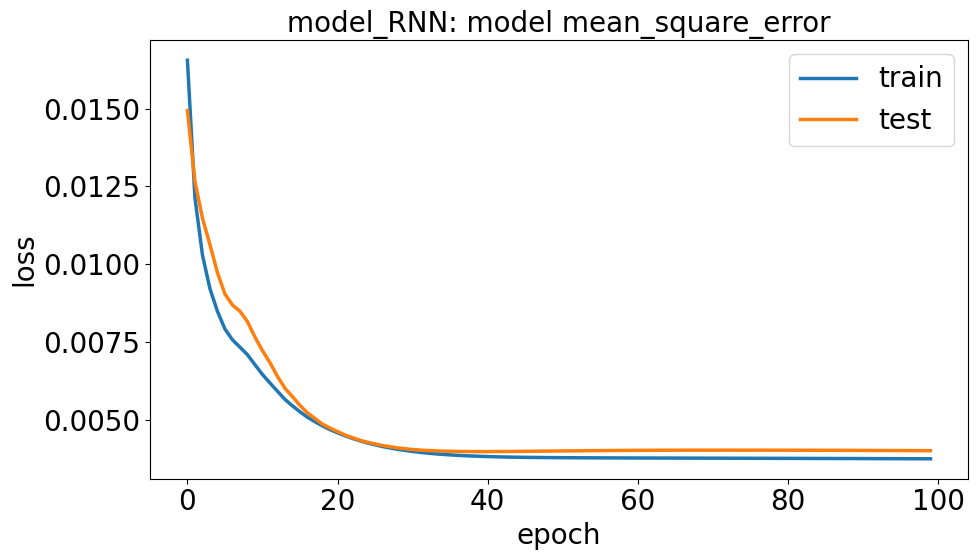

In [136]:
# plotting the metrics
fig = plt.figure(figsize = (10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_RNN: model mean_square_error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()


### 1.3) Entrenar el modelo LSTM:

Para definir una red recurrente vamos a construir un modelo secuencial al que se le agregará a nuestro una capa SimpleRNN.

Luego de la capa recurrente, debemos agregar una capa densa, la cual leerá el último estado del hidden space. En este caso, al tener un problema de regresión en el cual la salida del modelo debe ser un único valor numérico, vamos a utilizar como capa de salida una única unidad con activación lineal.

**Defino el modelo LSTM:**

In [137]:
# Defino el modelo_rnn:
model_lstm = Sequential()

# Defino el input
model_lstm.add(Input(shape=(look_back, n_features))) 

# Agrego una capa SimpleRNN:
model_lstm.add(LSTM(100, activation='tanh'))

# Agrego una capa de salida lineal:
model_lstm.add(Dense(1, activation='linear'))

# Compilamos el modelo:
model_lstm.compile(optimizer='adam', loss='mse')

**Entrenamos el modelo LSTM:**

In [138]:
history_lstm = model_lstm.fit(X_train, y_train, epochs=100, verbose=0,validation_data=(X_test, y_test))

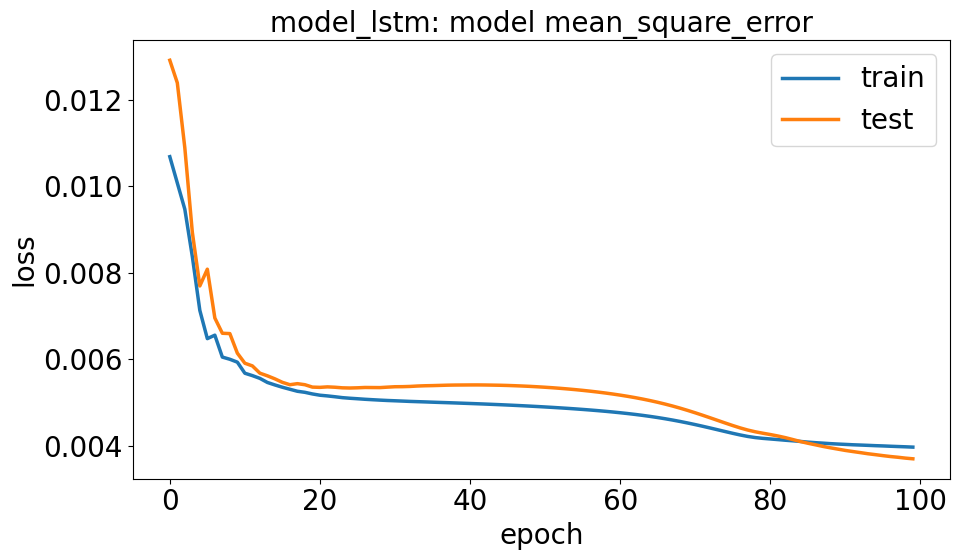

In [139]:
# plotting the metrics
fig = plt.figure(figsize = (10,6))
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model_lstm: model mean_square_error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()


In [140]:
# Anotacion: Inicialmente no habia normalizado, por lo que no lograba que la red se entrene correctamente.

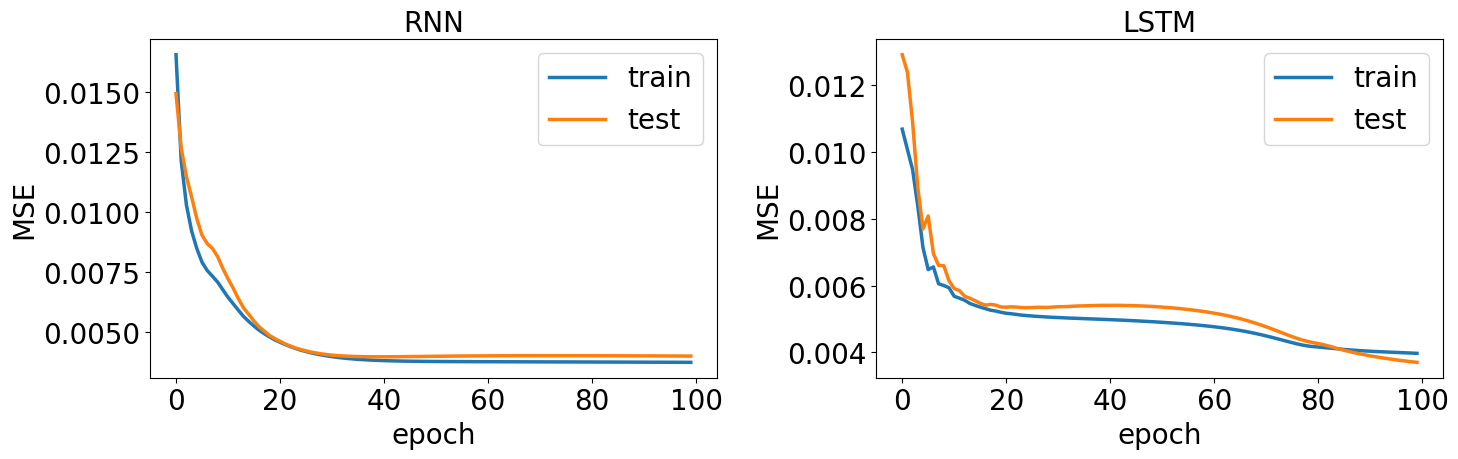

In [185]:

fig, axs = plt.subplots(1,2, figsize = (15,5))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('RNN')
axs[0].set_ylabel('MSE')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'test'], loc='upper right')

axs[1].plot(history_lstm.history['loss'])
axs[1].plot(history_lstm.history['val_loss'])
axs[1].set_title('LSTM')
axs[1].set_ylabel('MSE')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'test'], loc='upper right')

plt.tight_layout()

**Observaciones:**
1. La curva de aprendizaje de train baja muy rapido a casi 0: Sugiere que esta memorizando los datos.
2. La curva de test se mantiene alta respecto a la de train: Sugiere **overfitting**:

### 1.6) Evaluando los modelos:

In [142]:
df[train_index].shape

(115, 3)

Fijate que por el momento train_index considera los primeros 10 puntos de la secuencia. Nosotros sabemos que esos 10 puntos no pueden ser predichos porque conforman el primer look_back array.

In [143]:
train_index[:look_back+1] = False

In [144]:
df[train_index].shape

(104, 3)

Ahora si, eliminamos del indice (i.e. las fechas) los valores que no pueden ser poredichos.

#### 1.6.1) RNN: 1 Step-Forecasting:

In [145]:
P_train_rnn = model_rnn.predict(X_train).flatten()
P_test_rnn = model_rnn.predict(X_test).flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


In [146]:
P_train_rnn.shape # Fijate que es correcto que predecis 115 valores de la serie a partir de X_train. 

(104,)

In [147]:
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1) # Esto corre la serie una posición hacia abajo, de manera que a cada log(valor) en t le coloco al lado un 
prev = df['ShiftLogPassengers'] 

In [148]:
prev[train_index]

Month
1949-12-01    4.644391
1950-01-01    4.770685
1950-02-01    4.744932
1950-03-01    4.836282
1950-04-01    4.948760
                ...   
1958-03-01    5.762051
1958-04-01    5.891644
1958-05-01    5.852202
1958-06-01    5.894403
1958-07-01    6.075346
Name: ShiftLogPassengers, Length: 104, dtype: float64

In [149]:
# 1-step forecast
df.loc[train_index, '1step_train'] = prev[train_index] + P_train_rnn
df.loc[test_index, '1step_test'] = prev[test_index] + P_test_rnn

Text(0.5, 0, 'Year')

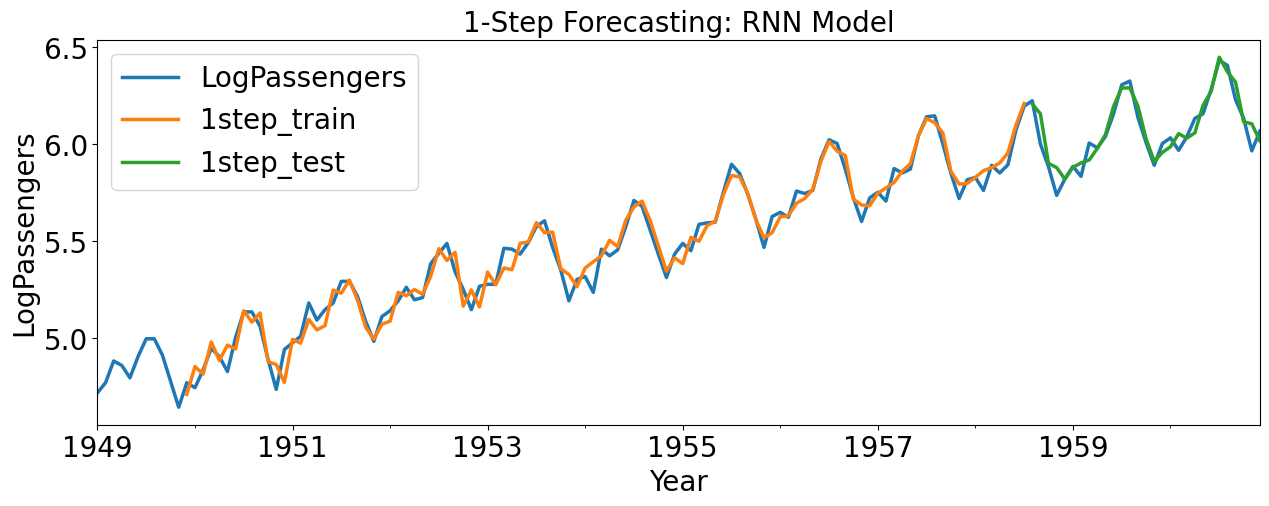

In [150]:
df[['LogPassengers', '1step_train', '1step_test']].plot(figsize=(15, 5))
plt.title('1-Step Forecasting: RNN Model')
plt.ylabel('LogPassengers')
plt.xlabel('Year')

Una predicción paso a paso (one-step ahead) para cada secuencia en `X_test`.

Para cada input en `X_test`, que es una ventana de `look_back` pasos previos, el modelo predice el siguiente valor `y_pred[i]` ≈ `y_test[i]`.Cada predicción es la estimación del valor siguiente inmediatamente después de la secuencia de entrada

#### 1.6.2) LSTM: 1 Step-Forecasting:

In [151]:
P_train_lstm = model_lstm.predict(X_train).flatten()
P_test_lstm = model_lstm.predict(X_test).flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


In [152]:
# 1-step forecast
df.loc[train_index, '1step_train_lstm'] = prev[train_index] + P_train_lstm
df.loc[test_index, '1step_test_lstm'] = prev[test_index] + P_test_lstm

Text(0.5, 0, 'Year')

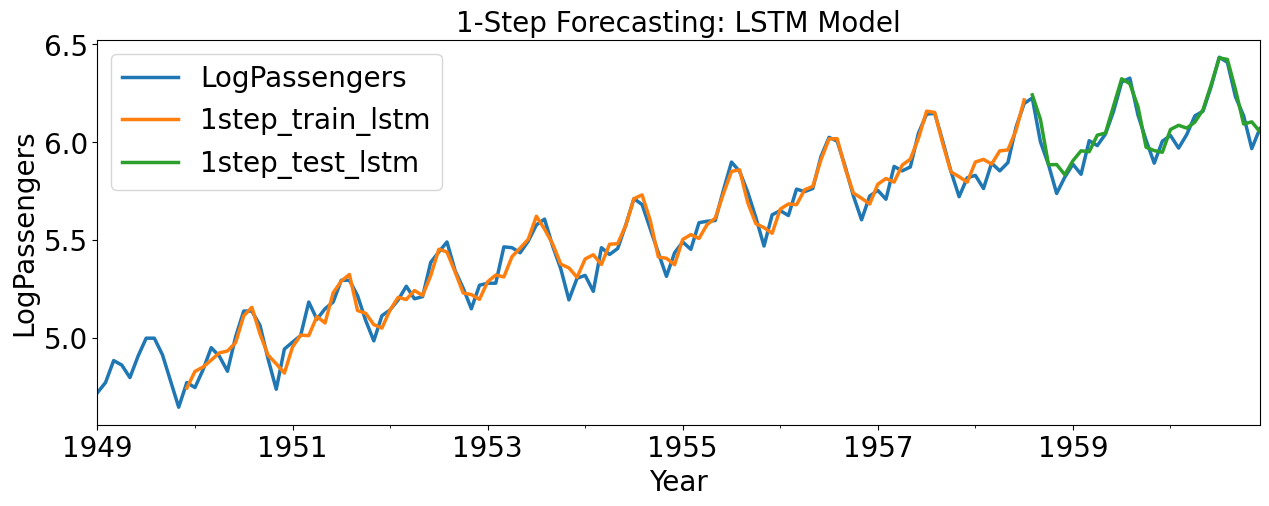

In [153]:
df[['LogPassengers', '1step_train_lstm', '1step_test_lstm']].plot(figsize=(15, 5))
plt.title('1-Step Forecasting: LSTM Model')
plt.ylabel('LogPassengers')
plt.xlabel('Year')

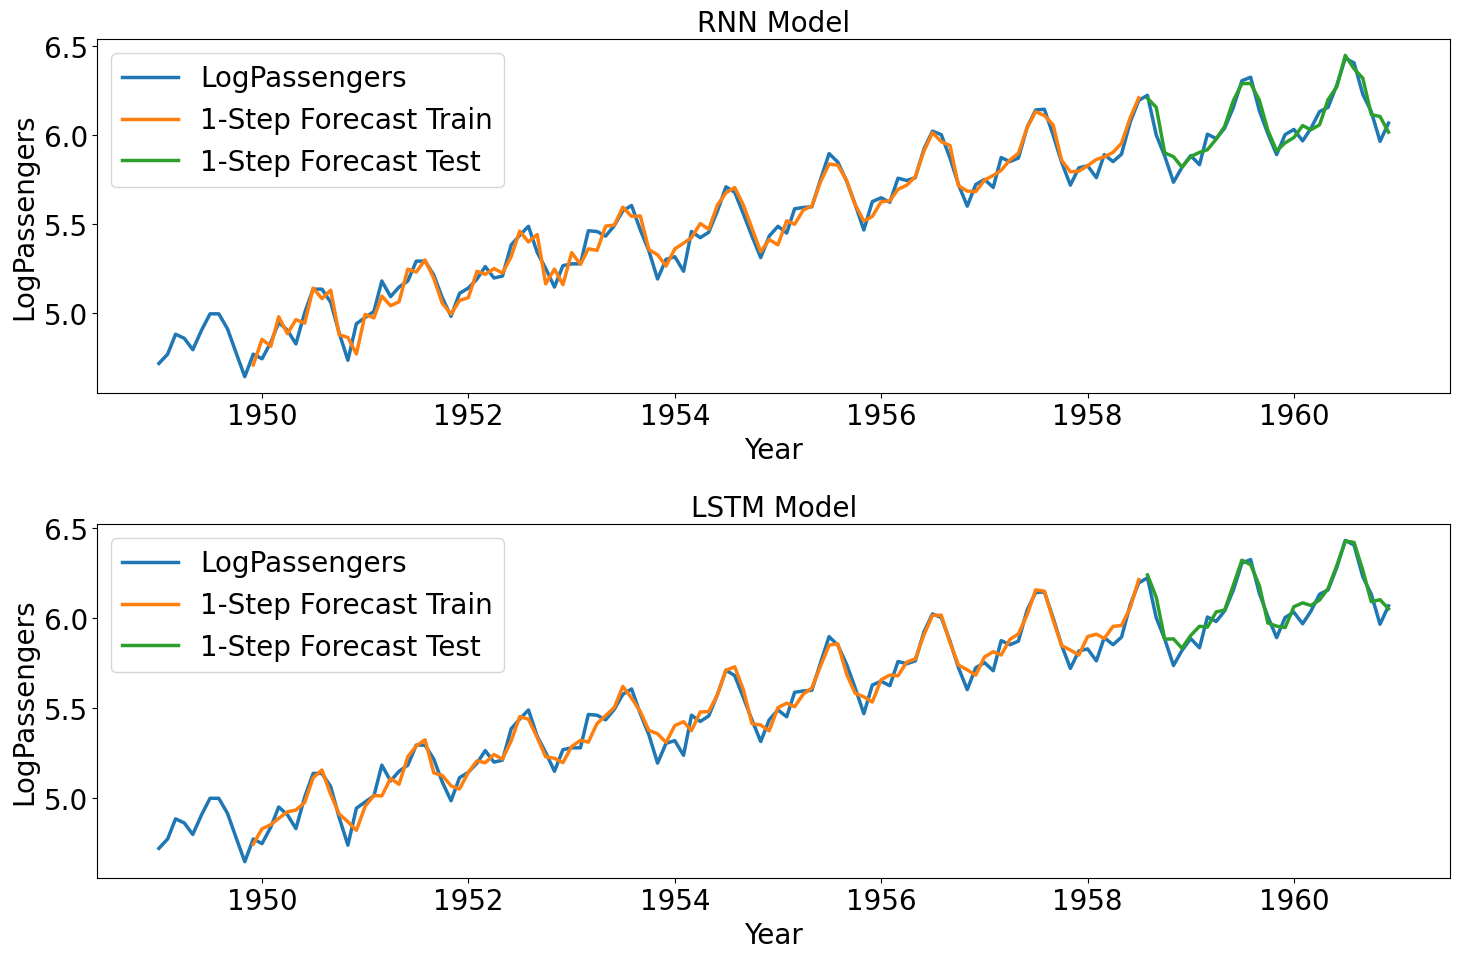

In [154]:
fig, axs = plt.subplots(2,1, figsize = (15,10))

axs[0].plot(df[['LogPassengers', '1step_train', '1step_test']])
axs[0].set_title('RNN Model')
axs[0].set_ylabel('LogPassengers')
axs[0].set_xlabel('Year')
axs[0].legend(['LogPassengers', '1-Step Forecast Train', '1-Step Forecast Test'])

axs[1].plot(df[['LogPassengers', '1step_train_lstm', '1step_test_lstm']])
axs[1].set_title('LSTM Model')
axs[1].set_ylabel('LogPassengers')
axs[1].set_xlabel('Year')
axs[1].legend(['LogPassengers', '1-Step Forecast Train', '1-Step Forecast Test'])

plt.tight_layout()

#### 1.6.3) MAPE for both RNN and LSTM models:

In [155]:

y_true = np.exp(df.iloc[-n_test:]['LogPassengers'])
y_pred_RNN = np.exp(df.loc[test_index, '1step_test'])
y_pred_LSTM = np.exp(df.loc[test_index, '1step_test_lstm'])

mape_rnn = mean_absolute_percentage_error(
    y_true, y_pred_RNN)*100

mape_lstm = mean_absolute_percentage_error(
    y_true, y_pred_LSTM)*100


print("1step_RNN - MAPE:", round(mape_rnn,2))
print("1step_LSTM - MAPE:", round(mape_lstm,2))


1step_RNN - MAPE: 4.81
1step_LSTM - MAPE: 4.62


### 1.7) Predicción Multi-Step (recursiva):

#### 1.7.1) Predicción Multi-Step RNN:

Para evaluar mejor el modelo, podemos ver que sucede cuando intento predecir multiples pasos en el tiempo. Para realizar esto, debemos predecir el siguiente paso y luego usar ese mismo paso como entrada de la proxima predicción y así sucesivamente.

In [156]:
X_test[0] # El primer punto de X_test

array([[-0.1520901 ],
       [-0.129013  ],
       [ 0.09679938],
       [ 0.01183446],
       [-0.06689423],
       [ 0.12959283],
       [-0.03944173],
       [ 0.04220035],
       [ 0.1809432 ],
       [ 0.1210981 ]])

In [157]:
X_test[0].shape

(10, 1)

In [158]:
X_test[0].reshape(1,-1,1).shape


# Entonces fijate que asi pasas el input al shape que necesita RNN/LSTM que es (batch, timesteps, features)

(1, 10, 1)

In [159]:
# Armo la lista en la que voy a ir guardando las predicciones:
multistep_predictions = []

# Llamo al primer input de X_test, que recorda, es un look_back array:
last_input = X_test[0]

# Armo el loop que se ejecutre mientra se cumpla condición:
while len(multistep_predictions) < n_test:
    p = model_rnn.predict(last_input.reshape(1,-1,1))[0][0]

    multistep_predictions.append(p)

    # Hago el nuevo input: Para eso primero corro los valores una posición a la izq, de manera que el primer valor del look_back ahora pasa a la ULTIMA posición.
    last_input = np.roll(last_input, -1)

    last_input[-1] = p # Entonces reemplazo el ultimo valor que solia ser el primero por la prediccion.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━

In [160]:
multistep_predictions

[0.011751982,
 -0.06384825,
 -0.12731543,
 -0.08947261,
 0.05128281,
 -0.05537531,
 0.016523244,
 0.037918646,
 -0.03675475,
 0.09766436,
 0.15048288,
 0.10155811,
 0.027187373,
 -0.02963647,
 -0.11718999,
 -0.04283218,
 -0.008216733,
 -0.052463517,
 0.021727666,
 -0.02175995,
 -0.002495062,
 0.10003779,
 0.12959357,
 0.092248246,
 0.05264605,
 -0.024069184,
 -0.08216357,
 -0.023104083,
 -0.04550209]

In [161]:
# Primero busco el last_train known value:

last_train = train.iloc[-1]['LogPassengers']
last_train

6.19644412779452

In [162]:
df.loc[test_index, 'multistep_rnn'] = last_train + np.cumsum(multistep_predictions)

# RECORDAR que cumsum calcula la suma del valor actual + el anterior y va por todo el array.
# Y aca tiene sentido porque la prediccion es la diff del log de la señal. Por lo que log(V_t) = Predicho + log(V_t-1).

Text(0, 0.5, 'LogPassengers')

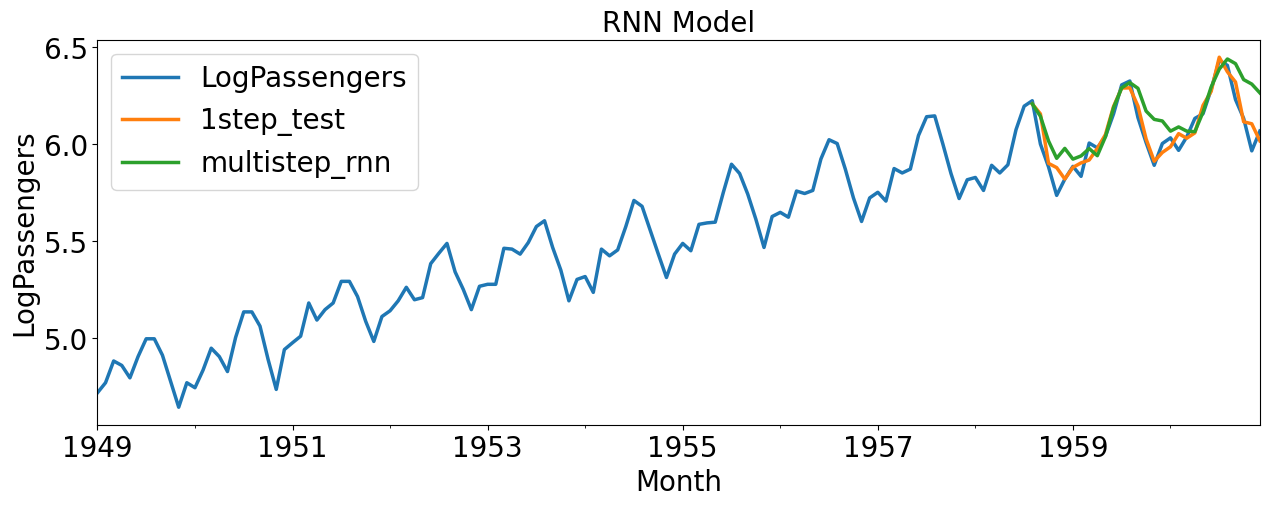

In [163]:
# plot 1-step forecast con multistep:

df[['LogPassengers', '1step_test', 'multistep_rnn']].plot(figsize=(15,5))
plt.title('RNN Model')
plt.ylabel('LogPassengers')

In [164]:
df['multistep_rnn_inverse'] = np.exp(df['multistep_rnn'])
df['1step_test_rnn_inverse'] = np.exp(df['1step_test'])

Text(0, 0.5, 'Passengers')

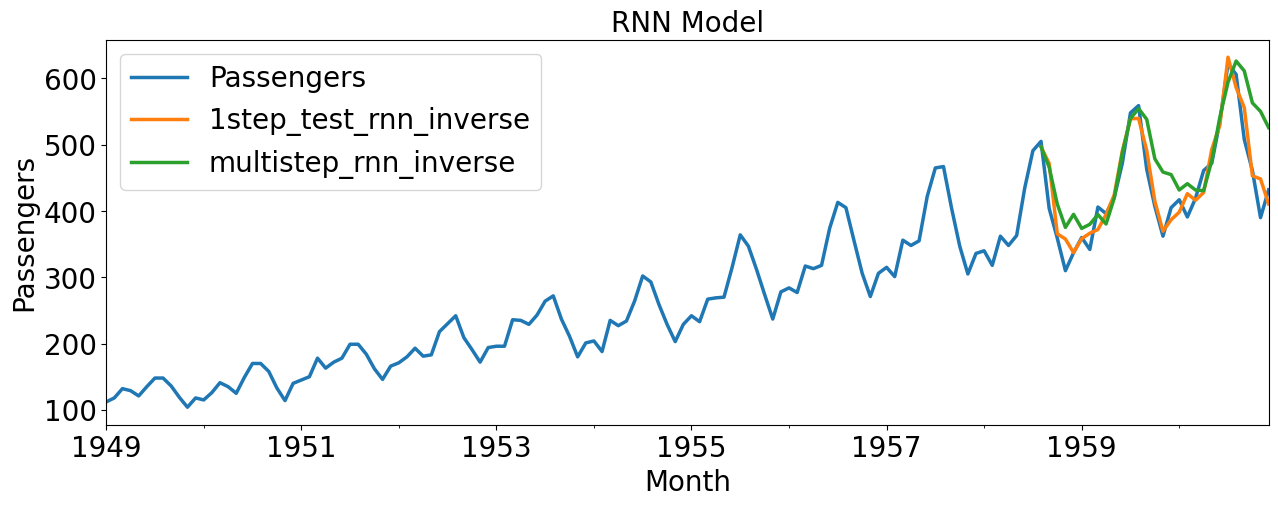

In [165]:
df[['Passengers', '1step_test_rnn_inverse', 'multistep_rnn_inverse']].plot(figsize=(15,5))
plt.title('RNN Model')
plt.ylabel('Passengers')

#### 1.7.1) Predicción Multi-Step LSTM:

In [166]:
# Armo la lista en la que voy a ir guardando las predicciones:
multistep_predictions_lstm = []

# Llamo al primer input de X_test, que recorda, es un look_back array:
last_input = X_test[0]

# Armo el loop que se ejecutre mientra se cumpla condición:
while len(multistep_predictions_lstm) < n_test:
    p = model_lstm.predict(last_input.reshape(1,-1,1))[0][0]

    multistep_predictions_lstm.append(p)

    # Hago el nuevo input: Para eso primero corro los valores una posición a la izq, de manera que el primer valor del look_back ahora pasa a la ULTIMA posición.
    last_input = np.roll(last_input, -1)

    last_input[-1] = p # Entonces reemplazo el ultimo valor que solia ser el primero por la prediccion.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━

In [167]:
df.loc[test_index, 'multistep_lstm'] = last_train + np.cumsum(multistep_predictions_lstm)

Text(0, 0.5, 'LogPassengers')

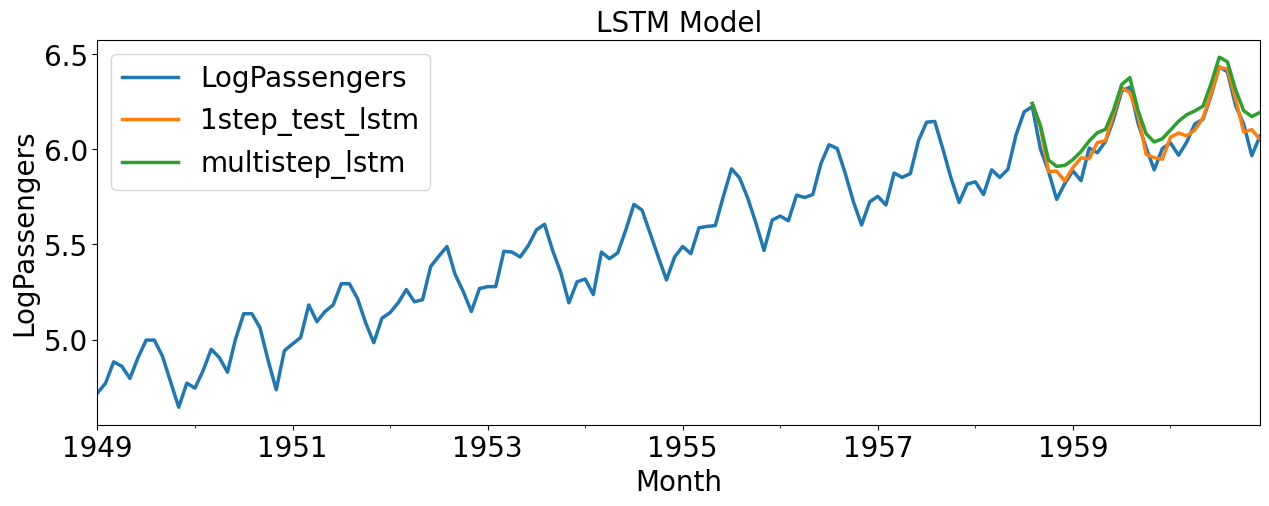

In [168]:
# plot 1-step forecast con multistep:

df[['LogPassengers', '1step_test_lstm', 'multistep_lstm']].plot(figsize=(15,5))
plt.title('LSTM Model')
plt.ylabel('LogPassengers')

In [169]:
df['multistep_lstm_inverse'] = np.exp(df['multistep_lstm'])
df['1step_test_lstm_inverse'] = np.exp(df['1step_test_lstm'])

Text(0, 0.5, 'Passengers')

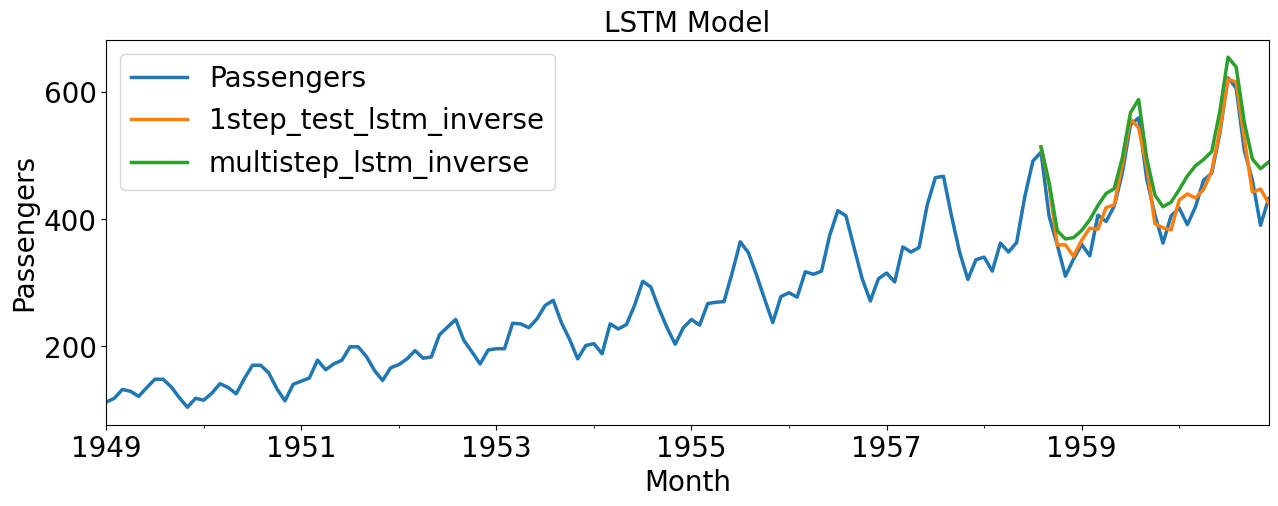

In [170]:
df[['Passengers', '1step_test_lstm_inverse', 'multistep_lstm_inverse']].plot(figsize=(15,5))
plt.title('LSTM Model')
plt.ylabel('Passengers')

### 1.8) MAPE for Multi-Step Forecasting:

In [171]:
from sklearn.metrics import  mean_absolute_percentage_error


y_true = np.exp(df.iloc[-n_test:]['LogPassengers'])
y_pred_RNN_multi = np.exp(df.loc[test_index, 'multistep_rnn'])
y_pred_LSTM_multi = np.exp(df.loc[test_index, 'multistep_lstm'])

mape_rnn = mean_absolute_percentage_error(
    y_true, y_pred_RNN_multi)*100

mape_lstm = mean_absolute_percentage_error(
    y_true, y_pred_LSTM_multi)*100


print("multistep_RNN - MAPE:", round(mape_rnn,2))
print("mulstistep_LSTM - MAPE:", round(mape_lstm,2))

multistep_RNN - MAPE: 10.73
mulstistep_LSTM - MAPE: 9.27


## 2) Modelado con Modelo de Holt Winters:

In [172]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [173]:
df['Passengers']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: Passengers, Length: 144, dtype: int64

In [174]:
N_train = int(0.8*len(df['Passengers']))
N_train

115

In [175]:
N_test = df.shape[0] - N_train

In [176]:
train = df.iloc[:N_train]
test = df.iloc[N_train:]

In [177]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='add', seasonal_periods=12)

result_hw = hw.fit()

/Users/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:465: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [178]:
train_index = train.index
test_index = test.index

In [179]:
df.loc[train_index, 'Holt Winters_train'] = result_hw.fittedvalues
df.loc[test_index, 'Holt Winters_test'] = result_hw.forecast(N_test) # N_test es el numero de puntos que tiene que forecastear

Text(0, 0.5, 'Passengers')

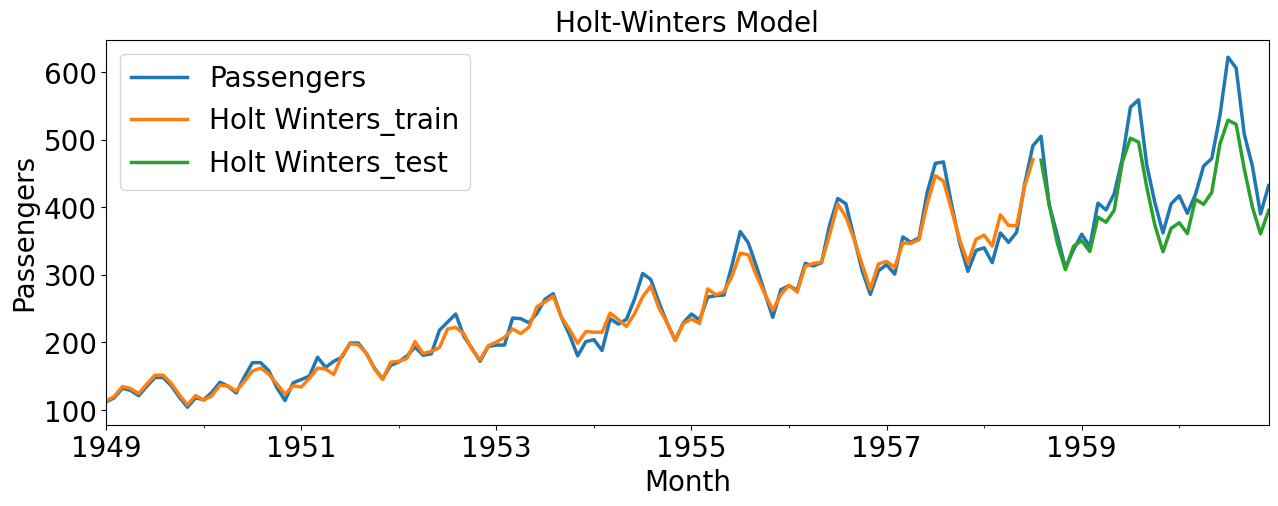

In [180]:
df[['Passengers', 'Holt Winters_train','Holt Winters_test']].plot(figsize = (15,5))
plt.title('Holt-Winters Model')
plt.ylabel('Passengers')

In [181]:
y_test_hw = test['Passengers']
y_test_hw_pred = df.loc[test_index, 'Holt Winters_test']

In [182]:
mape_hw_test = mean_absolute_percentage_error(y_test_hw, y_test_hw_pred) * 100 
round(mape_hw_test,2)

7.01

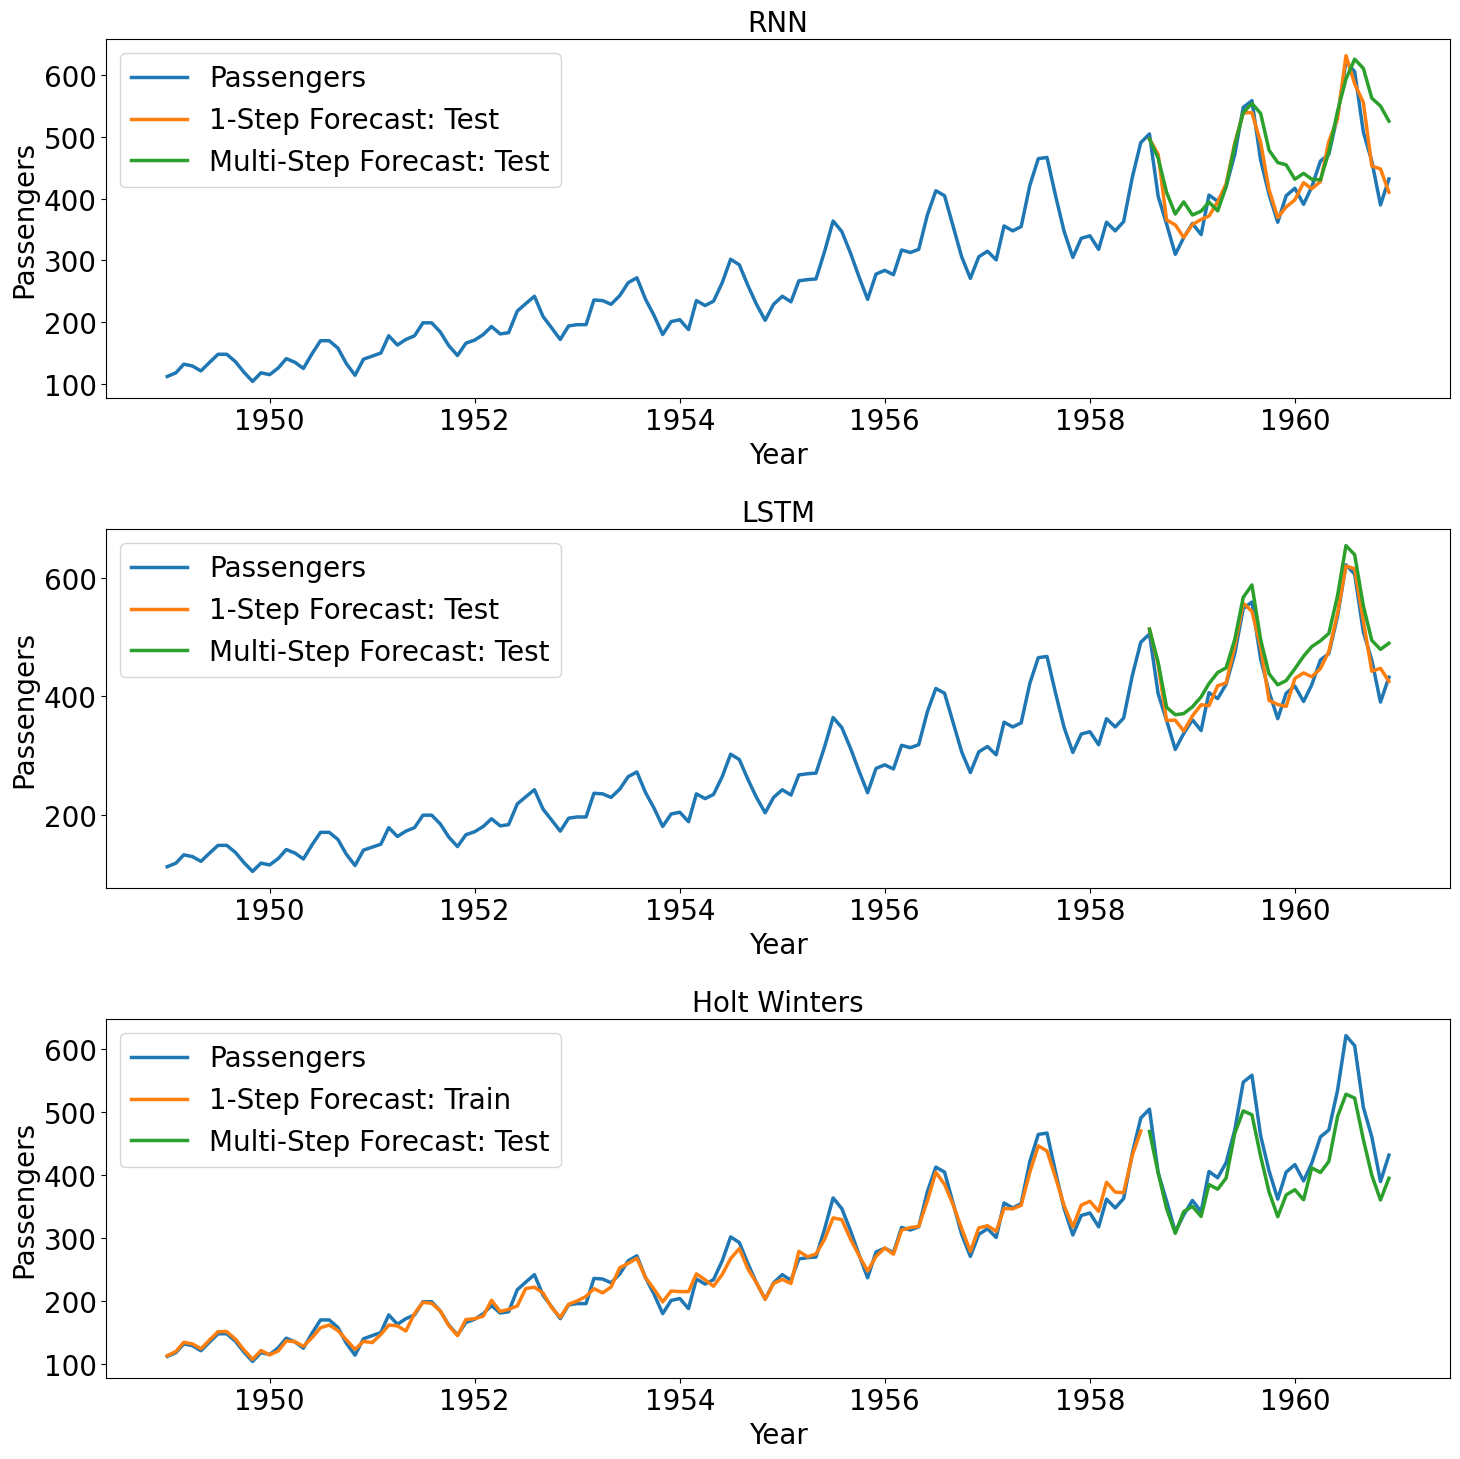

In [183]:
fig, axs = plt.subplots(3,1, figsize=(15,15))

axs[0].plot(df[['Passengers', '1step_test_rnn_inverse', 'multistep_rnn_inverse']])
axs[0].set_title('RNN')
axs[0].set_ylabel('Passengers')
axs[0].set_xlabel('Year')
axs[0].legend(['Passengers', '1-Step Forecast: Test', 'Multi-Step Forecast: Test'])

axs[1].plot(df[['Passengers', '1step_test_lstm_inverse', 'multistep_lstm_inverse']])
axs[1].set_title('LSTM')
axs[1].set_ylabel('Passengers')
axs[1].set_xlabel('Year')
axs[1].legend(['Passengers', '1-Step Forecast: Test', 'Multi-Step Forecast: Test'])

axs[2].plot(df[['Passengers', 'Holt Winters_train','Holt Winters_test']])
axs[2].set_title('Holt Winters')
axs[2].set_ylabel('Passengers')
axs[2].set_xlabel('Year')
axs[2].legend(['Passengers', '1-Step Forecast: Train', 'Multi-Step Forecast: Test'])


plt.tight_layout()

plt.savefig("multistep.png")

## 3) Conclusiones:

- **One-step (sobre LogPassengers)**: ambas redes predijeron con alta precisión — RNN MAPE 4.81% y LSTM MAPE 4.62%. 
- **Multi-step recursivo (escala original)**: se observó acumulación de error con el horizonte; Holt-Winters tuvo el mejor desempeño (MAPE 7.01%), superando a LSTM (9.27%) y RNN (10.73%).
- **Complejidad del modelo:** la RNN alcanzó su óptimo con ~15–30 unidades, mientras que la LSTM requirió ~100 unidades. 
- **Interpretación:** en series univariadas con patrones lineales y estacionales marcados, Holt-Winters puede superar a las redes en multi-step; las RNN/LSTM son competitivas a corto plazo y ganarían ventaja en problemas multivariados con relaciones no lineales y factores exógenos. 